# Run Inference

In [1]:
# imports
import random

# Torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Visualisation
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Local Packages
from dataset.SuperResolution import SRDataset
from nets.fsrcnn import FSRCNN
from nets.srcnn import SRCNN

from utils.vis import zoom_and_display_infer, zoom_and_display_data, zoom_and_display_results
from utils.vis import visualize_image, visualize_data, visualize_images

from utils.eval.mse import mse_loss
from utils.eval.psnr import psnr

C:\Users\angad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 1
EPOCHS = 200
LEARNING_RATE = 0.001
SCALE_FACTOR = 1  # No Downscaling

## Load the data

In [3]:
# Transform
transform = transforms.Compose([transforms.ToTensor(),])

# Create datasets
dataset = SRDataset('./test', transform=transform, mode='infer')

# Create dataloaders
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training examples: {len(dataset)}")
print(f"Shape of Dataloader: {next(iter(loader))[0].shape}")

Number of training examples: 1
Shape of Dataloader: torch.Size([3, 630, 1200])


## Visualize Data

In [4]:
randomize_idx = True  # Set to False to disable randomization

# Randomly select an image from the training set
set_length = len(dataset)
random_index = random.randint(0, set_length - 1) if randomize_idx else 0
print(f"Random index: {random_index}")

img = dataset[random_index]
print(img.shape)

Random index: 0
torch.Size([3, 630, 1200])


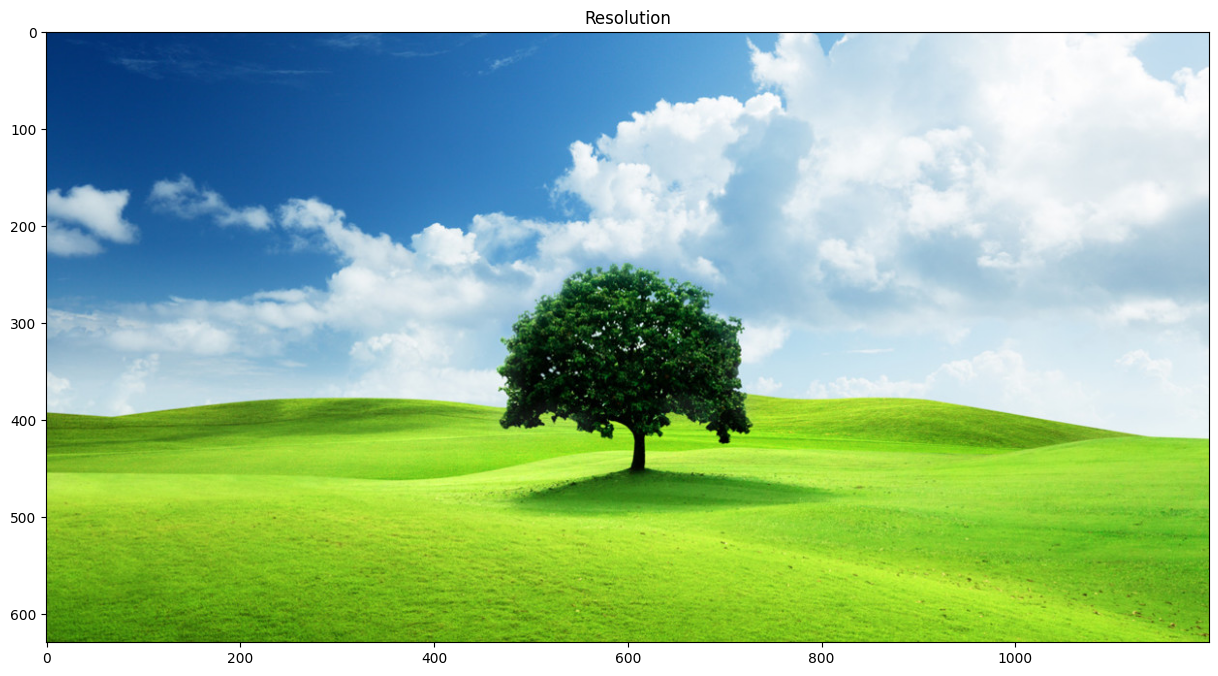

In [5]:
visualize_image(img)

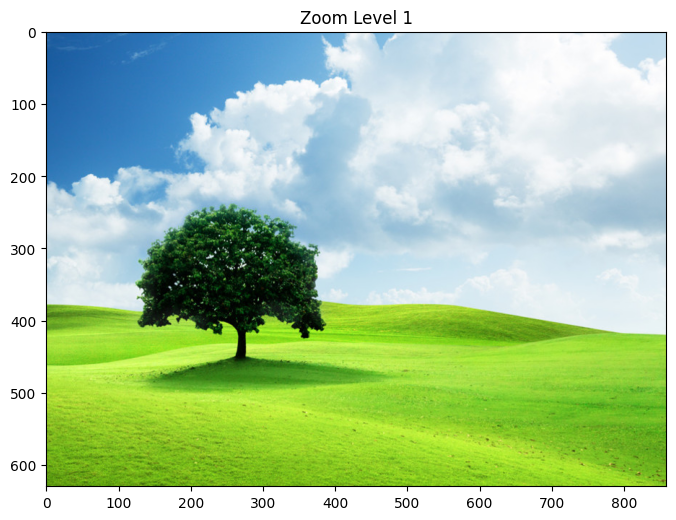

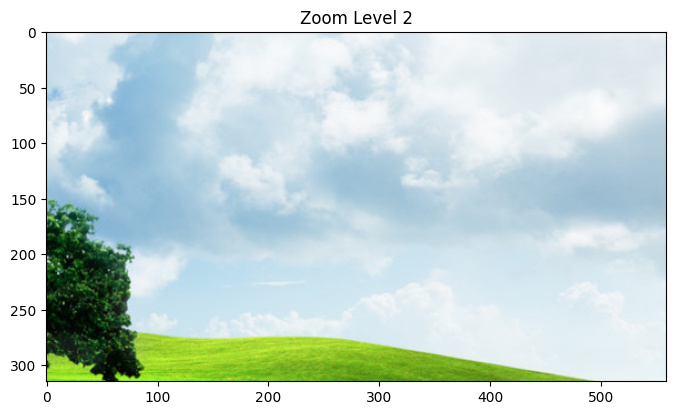

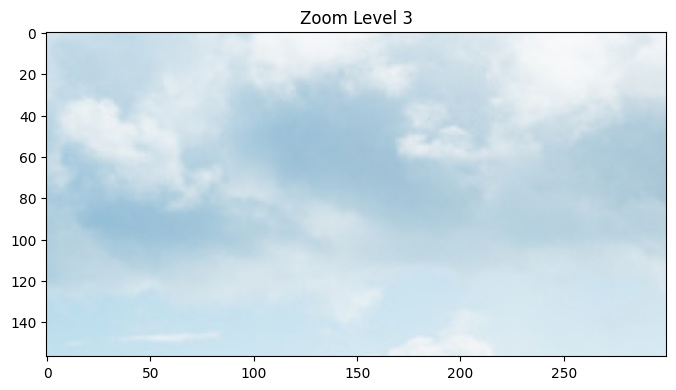

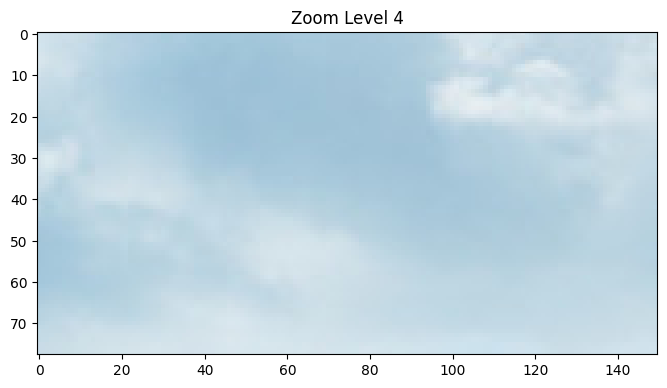

In [6]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
zoom_and_display_infer(img, num_zooms, randomize_point)

## Load the model

In [8]:
model_name = 'FSRCNN~100_2_16_0.001'  # Choose between 'SRCNN' and 'FSRCNN'
name = f'./models/{model_name}.pth'

# import model from state dict
model = FSRCNN(scale_factor=SCALE_FACTOR).to(device)
model.load_state_dict(torch.load(name))

# Set model to evaluation mode
model.eval()

FSRCNN(
  (first_part): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shrink): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (map): Sequential(
    (0): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(12, 12, kernel_size=(

## Visualize the output

In [9]:
# Function to update the plot
def update_plot(mse_list, psnr_list):
    plt.clf()  # Clear the current figure
    plt.subplot(2, 1, 1)
    plt.plot(mse_list, label='MSE')
    plt.title('Mean Squared Error over Batches')
    plt.xlabel('Batch')
    plt.ylabel('MSE')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(psnr_list, label='PSNR')
    plt.title('Peak Signal-to-Noise Ratio over Batches')
    plt.xlabel('Batch')
    plt.ylabel('PSNR')
    plt.legend()
    
    plt.draw()
    plt.pause(0.001)  # Pause to update the plot

def visualize_random_model(input_img, output_img, rand=True):
    if rand: random_index = random.randint(0, len(input_img) - 1)
    else: random_index = 0

    low_res = input_img[random_index].cpu().detach()
    up_res = output_img[random_index].cpu().detach()
    visualize_data(low_res, up_res)  # You will need to define this function


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


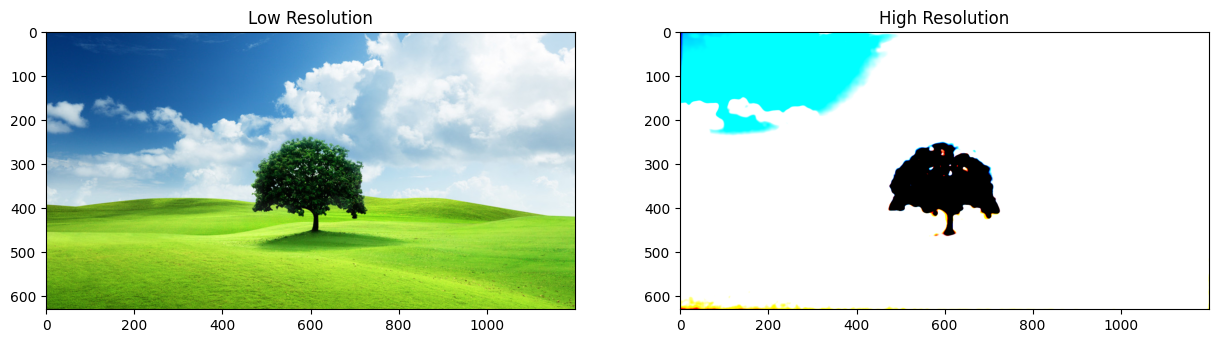

In [10]:
# Initialize interactive mode for plotting
plt.ion()

# Lists to store metric values
img_outputs = []

# Test loop
for inputs in loader:
    # Move data to device
    inputs = inputs.to(device)

    # Forward pass
    outputs = model(inputs)
    img_outputs.append(outputs)

    # Visualization of the images
    visualize_random_model(inputs, outputs)

# Disable interactive mode after testing
plt.ioff()

## Visualize Outputs

In [11]:
randomize_idx = True  # Set to False to disable randomization

# Randomly select an image from the testing set
set_length = len(dataset)
random_index = random.randint(0, set_length - 1) if randomize_idx else 0
print(f"Random index: {random_index}")

res = dataset[random_index]
up_res = img_outputs[random_index].squeeze(0).cpu().detach()
print(res.shape, up_res.shape)

Random index: 0
torch.Size([3, 630, 1200]) torch.Size([3, 630, 1200])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


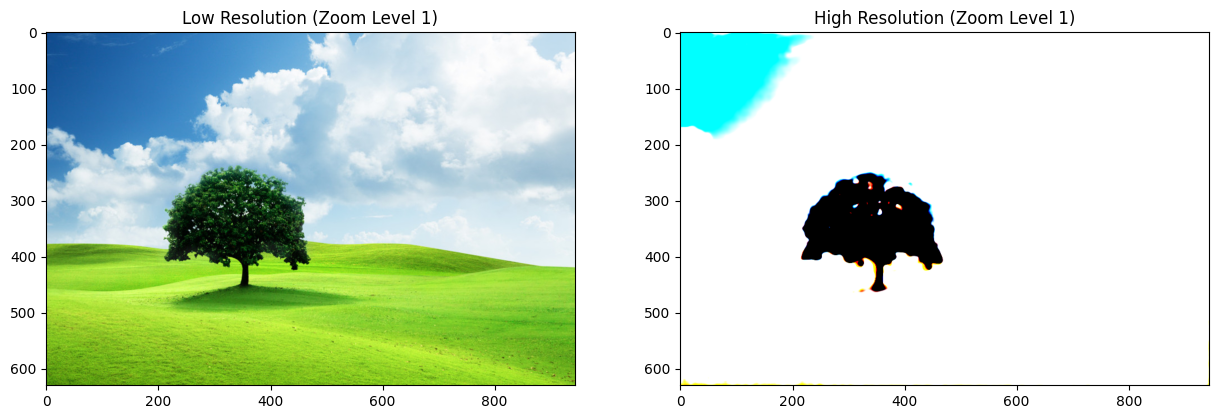

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


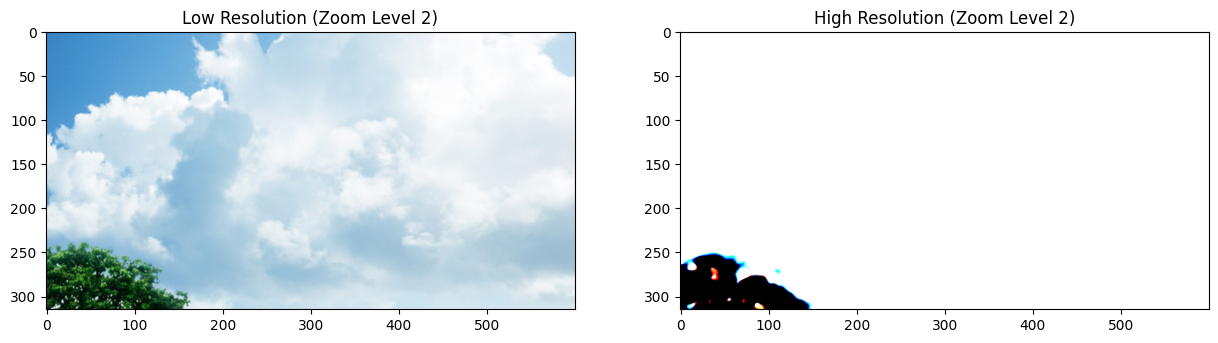

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


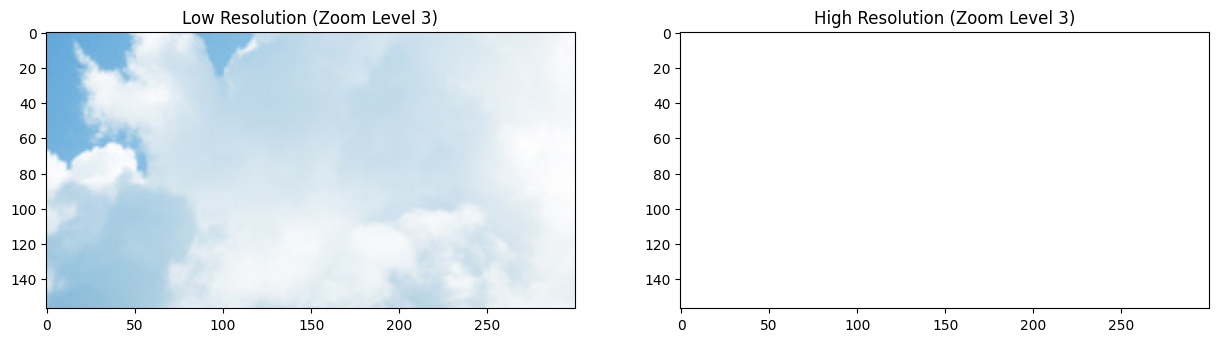

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


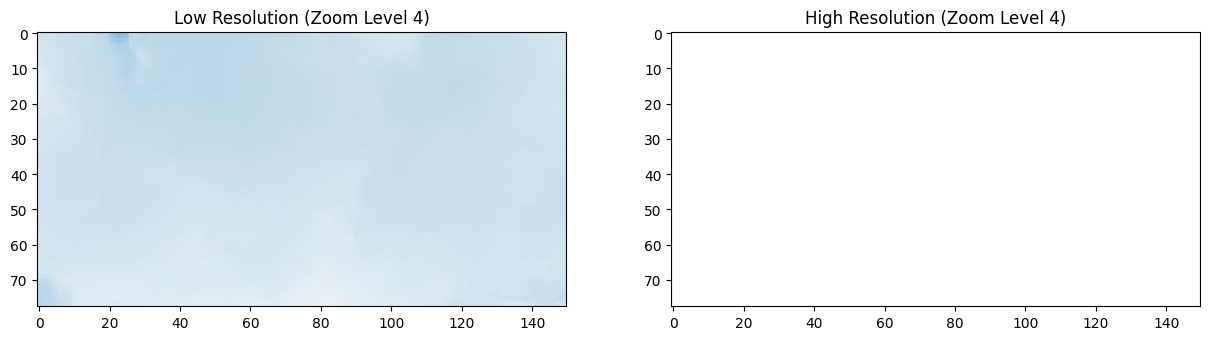

In [12]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
zoom_and_display_data(res, up_res, SCALE_FACTOR, num_zooms, randomize_point)